# **1. Install Requirement**

Pertama, dilakukan instalasi seluruh dependensi yang diperlukan untuk menjalankan proyek end-to-end. Pustaka utama meliputi:  
- **`google-play-scraper`**: Untuk mengambil data ulasan dari Google Play Store.  
- **`tensorflow`**: Sebagai framework deep learning untuk membangun model NLP.  
- **`sastrawi`**: Memfasilitasi preprocessing teks bahasa Indonesia (stemming dan stopword removal).  
- **`langdetect`**: Memastikan hanya ulasan berbahasa Indonesia yang diambil.  
- **`nltk`**: Mendukung tokenisasi dan manajemen stopword.  


In [ ]:
!pip install google-play-scraper pandas numpy matplotlib seaborn wordcloud tensorflow transformers sastrawi emoji tqdm nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 28.7 MB/s eta 0:00:00


In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=91677307d5c7ba9c1e4ddd5ac519f8c15b8dec6e61fff82f0c951b1d6f992061
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


# **2. Import Library**

Pada tahap ini, perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model yang diinginkan.

In [ ]:
# Import library yang diperlukan
import string
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, csv, time, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from collections import Counter
import emoji
from tqdm.notebook import tqdm


from langdetect import detect, DetectorFactory

# Library untuk scraping dari Google Play
from google_play_scraper import reviews as reviews_all, Sort

# Library Sastrawi untuk stemming dan stopword removal
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Embedding, Dense, LSTM, Bidirectional, GRU,
                                     Dropout, Conv1D, GlobalMaxPooling1D, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2

# Evaluasi
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Untuk eksperimen TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Untuk wordcloud
from wordcloud import WordCloud

# Download tambahan NLTK (untuk tokenisasi dan stopword jika diperlukan)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **3. Data Scrapping**

Menggunakan fungsi `scrape_google_play_reviews` untuk mengambil 60.000 ulasan game *Hay Day*:  
- **Parameter Kunci**:  
  - `app_id='com.supercell.hayday'`: Target aplikasi.  
  - `lang='id'` dan `country='id'`: Filter ulasan Indonesia.  
  - `count=10000`: Ambil 10.000 ulasan per batch.  
- **Mekanisme Anti-Duplikat**:  
  - Filter bahasa dengan `langdetect` untuk pastikan teks berbahasa Indonesia.  
  - Hapus duplikat dengan `drop_duplicates(subset=['content'])`.  
- **Penyimpanan Data**:  
  - Hasil scraping disimpan sebagai `hayday_reviews.csv` untuk analisis lanjutan.  


In [ ]:
# Fix seed untuk langdetect agar hasil konsisten
DetectorFactory.seed = 42

def is_indonesian(text):
    try:
        return detect(text) == 'id'
    except:
        return False  # Jika error, anggap bukan bahasa Indonesia

def scrape_google_play_reviews(app_id='com.supercell.hayday', target_reviews=60000):
    """
    Mengambil data review dari Google Play untuk aplikasi yang diinginkan.
    - app_id: ID aplikasi, default: Hay Day
    - target_reviews: target jumlah review (misalnya 60000)
    """
    all_reviews = []
    continuation_token = None

    # Loop hingga mencapai target atau data tidak lagi tersedia
    while len(all_reviews) < target_reviews:
        try:
            reviews_batch, continuation_token = reviews_all(
                app_id,
                lang='id',     # Hanya review berbahasa Indonesia
                country='id',  # Fokus ke Indonesia
                count=10000,   # Ambil 10000 review per batch jika memungkinkan
                continuation_token=continuation_token,
                sort=Sort.NEWEST  # Bisa diubah sesuai kebutuhan
            )
        except Exception as e:
            print("Terjadi error saat scraping:", e)
            break

        if not reviews_batch:
            break

        # Filter untuk pastikan review benar-benar berbahasa Indonesia
        reviews_batch = [review for review in reviews_batch if is_indonesian(review.get('content', ''))]

        all_reviews.extend(reviews_batch)

        print(f"Total review yang didapat: {len(all_reviews)}")

        if not continuation_token:
            break  # Berhenti jika tidak ada token lanjutannya

        time.sleep(2)  # Delay untuk menghindari request terlalu cepat

    # Konversi ke DataFrame dan pilih kolom yang diperlukan
    df = pd.DataFrame(all_reviews)[['content', 'score', 'at']]
    # Hapus duplikasi berdasarkan konten review
    df = df.drop_duplicates(subset=['content']).reset_index(drop=True)
    # Jika jumlah data kurang dari target, ambil sample dengan replace jika diperlukan
    if len(df) < target_reviews:
        df = df.sample(n=len(df), replace=False, random_state=42)
    else:
        df = df.sample(n=target_reviews, replace=False, random_state=42)

    return df

In [ ]:
# Eksekusi scraping
df_reviews = scrape_google_play_reviews(app_id='com.supercell.hayday', target_reviews=60000)
print("Scraping selesai. Total review:", len(df_reviews))

Total review yang didapat: 7359
Total review yang didapat: 14212
Total review yang didapat: 21282
Total review yang didapat: 27792
Total review yang didapat: 34623
Total review yang didapat: 40816
Total review yang didapat: 46622
Total review yang didapat: 52104
Total review yang didapat: 58031
Total review yang didapat: 63793
Scraping selesai. Total review: 55917


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55917 entries, 22581 to 15795
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   content  55917 non-null  object        
 1   score    55917 non-null  int64         
 2   at       55917 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
# Simpan hasil scraping ke CSV
df_reviews.to_csv('hayday_reviews.csv', index=False)
print("Data tersimpan di 'hayday_reviews.csv'")

Data tersimpan di 'hayday_reviews.csv'


# **4. Data Loading**

Memuat data dari data scrapping

In [ ]:
df_reviews.head()

,content,score,at
22581,masa aku kan beli brg hrsnya masuk ke lumbung ...,1,2021-04-07 13:01:57
44060,kenapa mesti di update terusss.. padahal ndak ...,2,2019-06-25 12:52:57
45025,Permainan Yg Berbagi Ilmu,5,2019-06-23 11:03:04
24957,"Baru juga diupdate, udah di-update lagi.. 😠",1,2020-12-14 14:15:47
49421,hay day menemani saya setiap hari,5,2019-01-26 23:35:29


In [ ]:
# Fungsi untuk loading data
def load_dataset(filepath='hayday_reviews.csv'):
    """Memuat dataset hasil scraping"""
    df = pd.read_csv(filepath)
    print(f"Data dimuat: {len(df)} baris")
    print("Contoh data:")
    print(df.head())
    return df

# Eksekusi loading data
df_loaded = load_dataset()

Data dimuat: 55917 baris
Contoh data:
                                             content  score  \
0  masa aku kan beli brg hrsnya masuk ke lumbung ...      1   
1  kenapa mesti di update terusss.. padahal ndak ...      2   
2                          Permainan Yg Berbagi Ilmu      5   
3        Baru juga diupdate, udah di-update lagi.. 😠      1   
4                  hay day menemani saya setiap hari      5   

                    at  
0  2021-04-07 13:01:57  
1  2019-06-25 12:52:57  
2  2019-06-23 11:03:04  
3  2020-12-14 14:15:47  
4  2019-01-26 23:35:29  


# **5. Data Preprocessing**

###**Slang Words**

Berisi kata-kata atau ungkapan informal yang digunakan dalam percakapan sehari-hari oleh kelompok tertentu

In [ ]:
SLANG_DICT = {'nerf': 'dilemahkan','buff': 'dikuatkan', 'op': 'terlalu kuat', 'noob': 'pemula','glitch': 'error', 'lag': 'lemot', 'wts': 'jual', 'best': 'terbaik',
              'wtb': 'beli', 'reroll': 'ulangi', 'add': 'tambahkan', 'farm': 'kumpulkan','xp': 'pengalaman', 'ngab': 'bang', 'santuy': 'santai', 'gas': 'cepat',
              'doge': 'anjing', 'mabar': 'main bareng', 'gws': 'cepat sembuh','wtf': 'astaga', 'lfg': 'cari tim', 'gg': 'permainan bagus', 'ndak' : 'tidak',
              'rip': 'meninggal', 'nub': 'pemula', 'ks': 'ambil kill', 'ngestack': 'tertahan', 'signal': 'sinyal', 'full': 'penuh', 'skali': 'sekali',
              'login': 'masuk akun', 'stuck': 'tertahan', 'loading': 'memuat', 'player': 'pemain', 'user': 'pengguna', 'game': 'permainan', 'fix': 'memperbaiki',
              'bug': 'kesalahan sistem', 'download': 'unduh', 'stck': 'tertahan', 'diamond': 'berlian', 'disconnect': 'terputus', 'connect': 'terhubung',
              'tw': 'tau', 'error': 'kesalahan', 'update': 'pembaruan', 'level': 'tingkat', 'hbs': 'habis', 'memory': 'memori', 'taik': 'kotoran', 'close': 'tutup',
              'open': 'buka', 'opening': 'pembuka', 'forced': 'dipaksa', 'met': 'selamat', 'yowes': 'ya sudah', 'stug': 'tertahan', 'lemot': 'lambat',
              'ilang': 'hilang', 'forclose': 'terpaksa keluar', 'gnti': 'ganti', 'x': 'kali', 'donlod': 'unduh', 'offline': 'luring', 'online': 'daring',
              'nyesel': 'menyesal', 'kluar': 'keluar', 'out': 'luar', 'developer': 'pengembang', 'exit': 'keluar', 'reinstall': 'instal ulang',
              '@': 'di', 'gini': 'begini', 'apk': 'aplikasi', 'pdhl': 'padahal', 'tdkdpt': 'tidak dapat', 'dg': 'dengan', 'bgus': 'bagus', 'nda': 'tidak',
              'dk': 'tidak', 'si': 'sih', 'c': 'sih', 'gabisa': 'tidak bisa', 'tru': 'trus', 'plu': 'plus', 'tetep': 'tetap', 'trus': 'terus',
              'eror': 'error', 'gitu': 'begitu', 'sdh': 'sudah', 'udh': 'sudah', 'g': 'bukan', 'gk': 'bukan', 'dr': 'dari', 'mw': 'mau',
              'ny': 'nya', 'ko': 'kok', 'skrg': 'sekarang', 'x': 'kali', 'app': 'aplikasi', 'rb': 'ribu', 'emang': 'memang', 'gem': 'game',
              'pa': 'apa', 'bagu': 'bagus', 'sya': 'saya', 'min': 'admin', 'sm': 'sama', 'abis': 'habis', 'wtb': 'beli',
              'masi': 'masih', 'wts': 'jual', 'wtt': 'tukar', 'bgt': 'banget', 'maks': 'maksimal', 'plisss': 'tolong', 'bgttt': 'banget',
              'indo': 'indonesia', 'bgtt': 'banget', 'ad': 'ada', 'rv': 'redvelvet', 'plis': 'tolong', 'pls': 'tolong', 'cr': 'sumber',
              'cod': 'bayar ditempat', 'adlh': 'adalah', 'afaik': 'as far as i know', 'ahaha': 'haha', 'aj': 'saja', 'gmn': 'gimana',
              'ajep-ajep': 'dunia gemerlap', 'ak': 'saya', 'akika': 'aku', 'akkoh': 'aku', 'akuwh': 'aku', 'alay': 'norak',
              'alow': 'halo', 'ambilin': 'ambilkan', 'ancur': 'hancur', 'anjrit': 'anjing', 'anter': 'antar', 'ap2': 'apa-apa',
              'apasih': 'apa sih', 'apes': 'sial', 'aps': 'apa', 'aq': 'saya', 'aquwh': 'aku', 'asbun': 'asal bunyi', 'aseekk': 'asyik',
              'asekk': 'asyik', 'asem': 'asam', 'aspal': 'asli tetapi palsu', 'astul': 'asal tulis', 'ato': 'atau', 'au ah': 'tidak mau tahu',
              'awak': 'saya', 'ay': 'sayang', 'ayank': 'sayang', 'b4': 'sebelum', 'bakalan': 'akan', 'bandes': 'bantuan desa',
              'bangedh': 'banget', 'banpol': 'bantuan polisi', 'banpur': 'bantuan tempur', 'basbang': 'basi', 'bcanda': 'bercanda', 'bdg': 'bandung',
              'begajulan': 'nakal', 'beliin': 'belikan', 'bencong': 'banci', 'bentar': 'sebentar', 'ber3': 'bertiga', 'beresin': 'membereskan',
              'bete': 'bosan', 'beud': 'banget', 'bg': 'abang', 'bgmn': 'bagaimana', 'bgt': 'banget', 'bijimane': 'bagaimana',
              'bintal': 'bimbingan mental', 'bkl': 'akan', 'bknnya': 'bukannya', 'blegug': 'bodoh', 'blh': 'boleh', 'bln': 'bulan', 'blum': 'belum',
              'bnci': 'benci', 'bnran': 'yang benar', 'bodor': 'lucu', 'bokap': 'ayah', 'boker': 'buang air besar', 'bokis': 'bohong',
              'boljug': 'boleh juga', 'bonek': 'bocah nekat', 'boyeh': 'boleh', 'br': 'baru', 'brg': 'bareng', 'bro': 'saudara laki-laki',
              'bru': 'baru', 'bs': 'bisa', 'bsen': 'bosan', 'bt': 'buat', 'btw': 'ngomong-ngomong', 'buaya': 'tidak setia', 'bubbu': 'tidur',
              'bubu': 'tidur', 'bumil': 'ibu hamil', 'bw': 'bawa', 'bwt': 'buat', 'byk': 'banyak', 'byrin': 'bayarkan', 'cabal': 'sabar',
              'cadas': 'keren', 'calo': 'makelar', 'can': 'belum', 'capcus': 'pergi', 'caper': 'cari perhatian', 'ce': 'cewek',
              'cekal': 'cegah tangkal', 'cemen': 'penakut', 'cengengesan': 'tertawa', 'cepet': 'cepat', 'cew': 'cewek', 'chuyunk': 'sayang',
              'cimeng': 'ganja', 'cipika cipiki': 'cium pipi kanan cium pipi kiri', 'ciyh': 'sih', 'ckepp': 'cakep', 'ckp': 'cakep',
              'cmiiw': "correct me if i'm wrong", 'cmpur': 'campur', 'cong': 'banci', 'cinlok': 'cinta lokasi', 'cowwyy': 'maaf',
              'cp': 'siapa', 'cpe': 'capek', 'cppe': 'capek', 'cucok': 'cocok', 'cuex': 'cuek', 'cumi': 'Cuma miscall', 'cups': 'culun',
              'curanmor': 'pencurian kendaraan bermotor', 'curcol': 'curahan hati colongan', 'cwek': 'cewek', 'cyin': 'cinta', 'd': 'di',
              'dah': 'deh', 'dapet': 'dapat', 'de': 'adik', 'dek': 'adik', 'demen': 'suka', 'deyh': 'deh', 'dgn': 'dengan', 'diancurin': 'dihancurkan',
              'dimaafin': 'dimaafkan', 'dimintak': 'diminta', 'disono': 'di sana', 'dket': 'dekat', 'dkk': 'dan kawan-kawan', 'dll': 'dan lain-lain',
              'dlu': 'dulu', 'dngn': 'dengan', 'dodol': 'bodoh', 'doku': 'uang', 'dongs': 'dong', 'dpt': 'dapat', 'dri': 'dari', 'drmn': 'darimana',
              'drtd': 'dari tadi', 'dst': 'dan seterusnya', 'dtg': 'datang', 'duh': 'aduh', 'duren': 'durian', 'ed': 'edisi', 'egp': 'emang gue pikirin',
              'eke': 'aku', 'elu': 'kamu', 'emangnya': 'memangnya', 'emng': 'memang', 'endak': 'tidak', 'enggak': 'tidak', 'envy': 'iri', 'ex': 'mantan',
              'fax': 'facsimile', 'fifo': 'first in first out', 'folbek': 'follow back', 'fyi': 'sebagai informasi', 'gaada': 'tidak ada uang',
              'gag': 'tidak', 'gaje': 'tidak jelas', 'gak papa': 'tidak apa-apa', 'gan': 'juragan', 'gaptek': 'gagap teknologi', 'gatek': 'gagap teknologi',
              'gawe': 'kerja', 'gbs': 'tidak bisa', 'gebetan': 'orang yang disuka', 'geje': 'tidak jelas', 'gepeng': 'gelandangan dan pengemis',
              'ghiy': 'lagi', 'gile': 'gila', 'gimana': 'bagaimana', 'gino': 'gigi nongol', 'githu': 'begitu', 'gj': 'tidak jelas',
              'gmana': 'bagaimana', 'gn': 'begini', 'goblok': 'bodoh', 'golput': 'golongan putih', 'gowes': 'mengayuh sepeda', 'gpny': 'tidak punya',
              'gr': 'gede rasa', 'gretongan': 'gratisan', 'gtau': 'tidak tahu', 'gua': 'saya', 'guoblok': 'goblok', 'gw': 'saya', 'ha': 'tertawa',
              'haha': 'tertawa', 'hallow': 'halo', 'hankam': 'pertahanan dan keamanan', 'hehe': 'he', 'helo': 'halo', 'hey': 'hai', 'hlm': 'halaman',
              'hny': 'hanya', 'hoax': 'isu bohong', 'hr': 'hari', 'hrus': 'harus', 'hubdar': 'perhubungan darat', 'huff': 'mengeluh', 'hum': 'rumah',
              'humz': 'rumah', 'ilang': 'hilang', 'ilfil': 'tidak suka', 'imho': 'in my humble opinion', 'imoetz': 'imut', 'item': 'hitam',
              'itungan': 'hitungan', 'iye': 'iya', 'ja': 'saja', 'jadiin': 'jadi', 'jaim': 'jaga image', 'jayus': 'tidak lucu', 'jdi': 'jadi',
              'jem': 'jam', 'jga': 'juga', 'jgnkan': 'jangankan', 'jir': 'anjing', 'jln': 'jalan', 'jomblo': 'tidak punya pacar',
              'jubir': 'juru bicara', 'jutek': 'galak', 'k': 'ke', 'kab': 'kabupaten', 'kabor': 'kabur', 'kacrut': 'kacau', 'kadiv': 'kepala divisi',
              'kagak': 'tidak', 'kalo': 'kalau', 'kampret': 'sialan', 'kamtibmas': 'keamanan dan ketertiban masyarakat', 'kamuwh': 'kamu',
              'kanwil': 'kantor wilayah', 'karna': 'karena', 'kasubbag': 'kepala subbagian', 'katrok': 'kampungan', 'kayanya': 'kayaknya',
              'kbr': 'kabar', 'kdu': 'harus', 'kec': 'kecamatan', 'kejurnas': 'kejuaraan nasional', 'kekeuh': 'keras kepala',
              'kel': 'kelurahan', 'kemaren': 'kemarin', 'kepengen': 'mau', 'kepingin': 'mau', 'kepsek': 'kepala sekolah', 'kesbang': 'kesatuan bangsa',
              'kesra': 'kesejahteraan rakyat', 'ketrima': 'diterima', 'kgiatan': 'kegiatan', 'kibul': 'bohong', 'kimpoi': 'kawin', 'kl': 'kalau',
              'klianz': 'kalian', 'kloter': 'kelompok terbang', 'klw': 'kalau', 'km': 'kamu', 'kmps': 'kampus', 'kmrn': 'kemarin', 'knal': 'kenal',
              'knp': 'kenapa', 'kodya': 'kota madya', 'komdis': 'komisi disiplin', 'komsov': 'komunis sovyet', 'kongkow': 'kumpul bareng teman-teman',
              'kopdar': 'kopi darat', 'korup': 'korupsi', 'kpn': 'kapan', 'krenz': 'keren', 'krm': 'kirim', 'kt': 'kita', 'ktmu': 'ketemu',
              'ktr': 'kantor', 'kuper': 'kurang pergaulan', 'kw': 'imitasi', 'kyk': 'seperti', 'la': 'lah', 'lam': 'salam', 'lamp': 'lampiran',
              'lanud': 'landasan udara', 'latgab': 'latihan gabungan', 'lebay': 'berlebihan', 'leh': 'boleh', 'lelet': 'lambat', 'lemot': 'lambat',
              'lgi': 'lagi', 'lgsg': 'langsung', 'liat': 'lihat', 'litbang': 'penelitian dan pengembangan', 'lmyn': 'lumayan', 'lo': 'kamu',
              'loe': 'kamu', 'lola': 'lambat berfikir', 'louph': 'cinta', 'low': 'kalau', 'lp': 'lupa', 'luber': 'langsung, umum, bebas, dan rahasia',
              'luchuw': 'lucu', 'lum': 'belum', 'luthu': 'lucu', 'lwn': 'lawan', 'maacih': 'terima kasih', 'mabal': 'bolos', 'macem': 'macam',
              'macih': 'masih', 'maem': 'makan', 'magabut': 'makan gaji buta', 'maho': 'homo', 'mak jang': 'kaget', 'maksain': 'memaksa',
              'malem': 'malam', 'mam': 'makan', 'maneh': 'kamu', 'maniez': 'manis', 'mao': 'mau', 'masukin': 'masukkan', 'melu': 'ikut',
              'mepet': 'dekat sekali', 'mgu': 'minggu', 'migas': 'minyak dan gas bumi', 'mikol': 'minuman beralkohol', 'miras': 'minuman keras',
              'mlah': 'malah', 'mngkn': 'mungkin', 'mo': 'mau', 'mokad': 'mati', 'moso': 'masa', 'mpe': 'sampai', 'msk': 'masuk', 'mslh': 'masalah',
              'mt': 'makan teman', 'mubes': 'musyawarah besar', 'mulu': 'melulu', 'mumpung': 'selagi', 'munas': 'musyawarah nasional',
              'muntaber': 'muntah dan berak', 'musti': 'mesti', 'muupz': 'maaf', 'mw': 'now watching', 'n': 'dan', 'nanam': 'menanam',
              'nanya': 'bertanya', 'napa': 'kenapa', 'napi': 'narapidana', 'napza': 'narkotika, alkohol, psikotropika, dan zat adiktif ',
              'narkoba': 'narkotika, psikotropika, dan obat terlarang', 'nasgor': 'nasi goreng', 'nda': 'tidak', 'ndiri': 'sendiri',
              'ne': 'ini', 'nekolin': 'neokolonialisme', 'nembak': 'menyatakan cinta', 'ngabuburit': 'menunggu berbuka puasa',
              'ngaku': 'mengaku', 'ngambil': 'mengambil', 'nganggur': 'tidak punya pekerjaan', 'ngapah': 'kenapa', 'ngaret': 'terlambat',
              'ngasih': 'memberikan', 'ngebandel': 'berbuat bandel', 'ngegosip': 'bergosip', 'ngeklaim': 'mengklaim', 'ngeksis': 'menjadi eksis',
              'ngeles': 'berkilah', 'ngelidur': 'menggigau', 'ngerampok': 'merampok', 'ngga': 'tidak', 'ngibul': 'berbohong', 'ngiler': 'mau',
              'ngiri': 'iri', 'ngisiin': 'mengisikan', 'ngmng': 'bicara', 'ngomong': 'bicara', 'ngubek2': 'mencari-cari', 'ngurus': 'mengurus',
              'nie': 'ini', 'nih': 'ini', 'niyh': 'nih', 'nmr': 'nomor', 'nntn': 'nonton', 'nobar': 'nonton bareng', 'np': 'now playing',
              'ntar': 'nanti', 'ntn': 'nonton', 'numpuk': 'bertumpuk', 'nutupin': 'menutupi', 'nyari': 'mencari', 'nyekar': 'menyekar',
              'nyicil': 'mencicil', 'nyoblos': 'mencoblos', 'nyokap': 'ibu', 'ogah': 'tidak mau', 'ol': 'online', 'ongkir': 'ongkos kirim',
              'oot': 'out of topic', 'org2': 'orang-orang', 'ortu': 'orang tua', 'otda': 'otonomi daerah', 'otw': 'on the way, sedang di jalan',
              'pacal': 'pacar', 'pake': 'pakai', 'pala': 'kepala', 'pansus': 'panitia khusus', 'parpol': 'partai politik',
              'pasutri': 'pasangan suami istri', 'pd': 'pada', 'pede': 'percaya diri', 'pelatnas': 'pemusatan latihan nasional',
              'pemda': 'pemerintah daerah', 'pemkot': 'pemerintah kota', 'pemred': 'pemimpin redaksi', 'penjas': 'pendidikan jasmani',
              'perda': 'peraturan daerah', 'perhatiin': 'perhatikan', 'pesenan': 'pesanan', 'pgang': 'pegang', 'pi': 'tapi',
              'pilkada': 'pemilihan kepala daerah', 'pisan': 'sangat', 'pk': 'penjahat kelamin', 'plg': 'paling', 'pmrnth': 'pemerintah',
              'polantas': 'polisi lalu lintas', 'ponpes': 'pondok pesantren', 'pp': 'pulang pergi', 'prg': 'pergi', 'prnh': 'pernah',
              'psen': 'pesan', 'pst': 'pasti', 'pswt': 'pesawat', 'pw': 'posisi nyaman', 'qmu': 'kamu', 'rakor': 'rapat koordinasi',
              'ranmor': 'kendaraan bermotor', 're': 'reply', 'ref': 'referensi', 'rehab': 'rehabilitasi', 'rempong': 'sulit',
              'repp': 'balas', 'restik': 'reserse narkotika', 'rhs': 'rahasia', 'rmh': 'rumah', 'ru': 'baru', 'ruko': 'rumah toko',
              'rusunawa': 'rumah susun sewa', 'ruz': 'terus', 'saia': 'saya', 'salting': 'salah tingkah', 'sampe': 'sampai',
              'samsek': 'sama sekali', 'sapose': 'siapa', 'satpam': 'satuan pengamanan', 'sbb': 'sebagai berikut', 'sbh': 'sebuah',
              'sbnrny': 'sebenarnya', 'scr': 'secara', 'sdgkn': 'sedangkan', 'sdkt': 'sedikit', 'se7': 'setuju', 'sebelas dua belas': 'mirip',
              'sembako': 'sembilan bahan pokok', 'sempet': 'sempat', 'sendratari': 'seni drama tari', 'sgt': 'sangat', 'shg': 'sehingga',
              'siech': 'sih', 'sikon': 'situasi dan kondisi', 'sinetron': 'sinema elektronik', 'siramin': 'siramkan', 'sj': 'saja',
              'skalian': 'sekalian', 'sklh': 'sekolah', 'skt': 'sakit', 'slesai': 'selesai', 'sll': 'selalu', 'slma': 'selama',
              'slsai': 'selesai', 'smpt': 'sempat', 'smw': 'semua', 'sndiri': 'sendiri', 'soljum': 'sholat jumat', 'songong': 'sombong',
              'sory': 'maaf', 'sosek': 'sosial-ekonomi', 'sotoy': 'sok tahu', 'spa': 'siapa', 'sppa': 'siapa', 'spt': 'seperti',
              'srtfkt': 'sertifikat', 'stiap': 'setiap', 'stlh': 'setelah', 'suk': 'masuk', 'sumpek': 'sempit', 'syg': 'sayang',
              't4': 'tempat', 'tajir': 'kaya', 'tau': 'tahu', 'taw': 'tahu', 'td': 'tadi', 'tdk': 'tidak', 'teh': 'kakak perempuan',
              'telat': 'terlambat', 'telmi': 'telat berpikir', 'temen': 'teman', 'tengil': 'menyebalkan', 'tepar': 'terkapar',
              'tggu': 'tunggu', 'tgu': 'tunggu', 'thankz': 'terima kasih', 'thn': 'tahun', 'tilang': 'bukti pelanggaran', 'tipiwan': 'TvOne',
              'tks': 'terima kasih', 'tlp': 'telepon', 'tls': 'tulis', 'tmbah': 'tambah', 'tmen2': 'teman-teman', 'tmpah': 'tumpah',
              'tmpt': 'tempat', 'tngu': 'tunggu', 'tnyta': 'ternyata', 'tokai': 'tai', 'toserba': 'toko serba ada', 'tpi': 'tapi',
              'trdhulu': 'terdahulu', 'trima': 'terima kasih', 'trm': 'terima', 'trs': 'terus', 'trutama': 'terutama', 'ts': 'penulis',
              'tst': 'tahu sama tahu', 'ttg': 'tentang', 'tuch': 'tuh', 'tuir': 'tua', 'tw': 'tahu', 'u': 'kamu', 'ud': 'sudah', 'udah': 'sudah',
              'ujg': 'ujung', 'ul': 'ulangan', 'unyu': 'lucu', 'uplot': 'unggah', 'urang': 'saya', 'usah': 'perlu', 'utk': 'untuk',
              'valas': 'valuta asing', 'w/': 'dengan', 'wadir': 'wakil direktur', 'wamil': 'wajib militer', 'warkop': 'warung kopi',
              'warteg': 'warung tegal', 'wat': 'buat', 'wkt': 'waktu', 'wtf': 'what the fuck', 'xixixi': 'tertawa', 'ya': 'iya', 'yap': 'iya',
              'yaudah': 'ya sudah', 'yawdah': 'ya sudah', 'yg': 'yang', 'yl': 'yang lain', 'yo': 'iya', 'yowes': 'ya sudah', 'yup': 'iya',
              '7an': 'tujuan', 'ababil': 'abg labil', 'acc': 'accord', 'adlah': 'adalah', 'adoh': 'aduh', 'aha': 'tertawa', 'aing': 'saya',
              'aja': 'saja', 'ajj': 'saja', 'aka': 'dikenal juga sebagai', 'akko': 'aku', 'akku': 'aku', 'akyu': 'aku', 'aljasa': 'asal jadi saja',
              'ama': 'sama', 'ambl': 'ambil', 'anjir': 'anjing', 'ank': 'anak', 'ap': 'apa', 'apaan': 'apa', 'ape': 'apa', 'aplot': 'unggah',
              'apva': 'apa', 'aqu': 'aku', 'asap': 'sesegera mungkin', 'aseek': 'asyik', 'asek': 'asyik', 'aseknya': 'asyiknya', 'asoy': 'asyik',
              'astrojim': 'astagfirullahaladzim', 'ath': 'kalau begitu', 'atuh': 'kalau begitu', 'ava': 'avatar', 'aws': 'awas', 'ayang': 'sayang',
              'ayok': 'ayo', 'bacot': 'banyak bicara', 'bales': 'balas', 'bangdes': 'pembangunan desa', 'bangkotan': 'tua', 'banpres': 'bantuan presiden',
              'bansarkas': 'bantuan sarana kesehatan', 'bazis': 'badan amal, zakat, infak, dan sedekah', 'bcoz': 'karena', 'beb': 'sayang',
              'bejibun': 'banyak', 'belom': 'belum', 'bener': 'benar', 'ber2': 'berdua', 'berdikari': 'berdiri di atas kaki sendiri', 'bet': 'banget',
              'beti': 'beda tipis', 'beut': 'banget', 'bgd': 'banget', 'bgs': 'bagus', 'bhubu': 'tidur', 'bimbuluh': 'bimbingan dan penyuluhan',
              'bisi': 'kalau-kalau', 'bkn': 'bukan', 'bl': 'beli', 'blg': 'bilang', 'blm': 'belum', 'bls': 'balas', 'bnchi': 'benci', 'bngung': 'bingung',
              'bnyk': 'banyak', 'bohay': 'badan aduhai', 'bokep': 'porno', 'bokin': 'pacar', 'bole': 'boleh', 'bolot': 'bodoh', 'bonyok': 'ayah ibu',
              'bpk': 'bapak', 'brb': 'segera kembali', 'brngkt': 'berangkat', 'brp': 'berapa', 'brur': 'saudara laki-laki', 'bsa': 'bisa',
              'bsk': 'besok', 'bu_bu': 'tidur', 'bubarin': 'bubarkan', 'buber': 'buka bersama', 'bujubune': 'luar biasa', 'buser': 'buru sergap',
              'bwhn': 'bawahan', 'byar': 'bayar', 'byr': 'bayar', 'c8': 'chat', 'cabut': 'pergi', 'caem': 'cakep', 'cama-cama': 'sama-sama',
              'cangcut': 'celana dalam', 'cape': 'capek', 'caur': 'jelek', 'cekak': 'tidak ada uang', 'cekidot': 'coba lihat',
              'cemplungin': 'cemplungkan', 'ceper': 'pendek', 'ceu': 'kakak perempuan', 'cewe': 'cewek', 'cibuk': 'sibuk', 'cin': 'cinta',
              'ciye': 'cie', 'ckck': 'ck', 'clbk': 'cinta lama bersemi kembali', 'cmpr': 'campur', 'cnenk': 'senang', 'congor': 'mulut',
              'cow': 'cowok', 'coz': 'karena', 'cpa': 'siapa', 'gokil': 'gila', 'gombal': 'suka merayu', 'gpl': 'tidak pakai lama',
              'gpp': 'tidak apa-apa', 'gretong': 'gratis', 'gt': 'begitu', 'gtw': 'tidak tahu', 'gue': 'saya', 'guys': 'teman-teman',
              'gws': 'cepat sembuh', 'haghaghag': 'tertawa', 'hakhak': 'tertawa', 'handak': 'bahan peledak', 'hansip': 'pertahanan sipil',
              'hellow': 'halo', 'helow': 'halo', 'hi': 'hai', 'hlng': 'hilang', 'hnya': 'hanya', 'houm': 'rumah', 'hrs': 'harus',
              'hubad': 'hubungan angkatan darat', 'hubla': 'perhubungan laut', 'huft': 'mengeluh', 'humas': 'hubungan masyarakat',
              'idk': 'saya tidak tahu', 'ilfeel': 'tidak suka', 'imba': 'jago sekali', 'imoet': 'imut', 'info': 'informasi',
              'itung': 'hitung', 'isengin': 'bercanda', 'iyala': 'iya lah', 'iyo': 'iya', 'jablay': 'jarang dibelai', 'jadul': 'jaman dulu',
              'jancuk': 'anjing', 'jd': 'jadi', 'jdikan': 'jadikan', 'jg': 'juga', 'jgn': 'jangan', 'jijay': 'jijik', 'jkt': 'jakarta',
              'jnj': 'janji', 'jth': 'jatuh', 'jurdil': 'jujur adil', 'jwb': 'jawab', 'ka': 'kakak', 'kabag': 'kepala bagian', 'kacian': 'kasihan',
              'kadit': 'kepala direktorat', 'kaga': 'tidak', 'kaka': 'kakak', 'kamtib': 'keamanan dan ketertiban', 'kamuh': 'kamu', 'kamyu': 'kamu',
              'kapt': 'kapten', 'kasat': 'kepala satuan', 'kasubbid': 'kepala subbidang', 'kau': 'kamu', 'kbar': 'kabar', 'kcian': 'kasihan',
              'keburu': 'terlanjur', 'kedubes': 'kedutaan besar', 'kek': 'seperti', 'keknya': 'kayaknya', 'keliatan': 'kelihatan', 'keneh': 'masih',
              'kepikiran': 'terpikirkan', 'kepo': 'mau tahu urusan orang', 'kere': 'tidak punya uang', 'kesian': 'kasihan', 'ketauan': 'ketahuan',
              'keukeuh': 'keras kepala', 'khan': 'kan', 'kibus': 'kaki busuk', 'kk': 'kakak', 'klian': 'kalian', 'klo': 'kalau', 'kluarga': 'keluarga',
              'klwrga': 'keluarga', 'kmari': 'kemari', 'kmpus': 'kampus', 'kn': 'kan', 'knl': 'kenal', 'knpa': 'kenapa', 'kog': 'kok', 'kompi': 'komputer',
              'komtiong': 'komunis Tiongkok', 'konjen': 'konsulat jenderal', 'koq': 'kok', 'kpd': 'kepada', 'kptsan': 'keputusan', 'krik': 'garing',
              'krn': 'karena', 'ktauan': 'ketahuan', 'ktny': 'katanya', 'kudu': 'harus', 'kuq': 'kok', 'ky': 'seperti', 'kykny': 'kayanya',
              'laka': 'kecelakaan', 'lambreta': 'lambat', 'lansia': 'lanjut usia', 'lapas': 'lembaga pemasyarakatan', 'lbur': 'libur',
              'lekong': 'laki-laki', 'lg': 'lagi', 'lgkp': 'lengkap', 'lht': 'lihat', 'linmas': 'perlindungan masyarakat', 'lmyan': 'lumayan',
              'lngkp': 'lengkap', 'loch': 'loh', 'lol': 'tertawa', 'lom': 'belum', 'loupz': 'cinta', 'lowh': 'kamu', 'lu': 'kamu', 'luchu': 'lucu',
              'luff': 'cinta', 'luph': 'cinta', 'lw': 'kamu', 'lwt': 'lewat', 'maaciw': 'terima kasih', 'mabes': 'markas besar',
              'macem-macem': 'macam-macam', 'madesu': 'masa depan suram', 'maen': 'main', 'mahatma': 'maju sehat bersama', 'mak': 'ibu',
              'makasih': 'terima kasih', 'malah': 'bahkan', 'malu2in': 'memalukan', 'mamz': 'makan', 'manies': 'manis', 'mantep': 'mantap',
              'markus': 'makelar kasus', 'mba': 'mbak', 'mending': 'lebih baik', 'mgkn': 'mungkin', 'mhn': 'mohon', 'miker': 'minuman keras',
              'milis': 'mailing list', 'mksd': 'maksud', 'mls': 'malas', 'mnt': 'minta', 'moge': 'motor gede', 'mokat': 'mati', 'mosok': 'masa',
              'msh': 'masih', 'mskpn': 'meskipun', 'msng2': 'masing-masing', 'muahal': 'mahal', 'muker': 'musyawarah kerja', 'mumet': 'pusing',
              'muna': 'munafik', 'munaslub': 'musyawarah nasional luar biasa', 'musda': 'musyawarah daerah', 'muup': 'maaf', 'muuv': 'maaf',
              'nal': 'kenal', 'nangis': 'menangis', 'naon': 'apa', 'napol': 'narapidana politik', 'naq': 'anak', 'narsis': 'bangga pada diri sendiri',
              'nax': 'anak', 'ndak': 'tidak', 'ndut': 'gendut', 'nekolim': 'neokolonialisme', 'nelfon': 'menelepon', 'ngabis2in': 'menghabiskan',
              'ngakak': 'tertawa', 'ngambek': 'marah', 'ngampus': 'pergi ke kampus', 'ngantri': 'mengantri', 'ngapain': 'sedang apa',
              'ngaruh': 'berpengaruh', 'ngawur': 'berbicara sembarangan', 'ngeceng': 'kumpul bareng-bareng', 'ngeh': 'sadar', 'ngekos': 'tinggal di kos',
              'ngelamar': 'melamar', 'ngeliat': 'melihat', 'ngemeng': 'bicara terus-terusan', 'ngerti': 'mengerti', 'nggak': 'tidak',
              'ngikut': 'ikut', 'nginep': 'menginap', 'ngisi': 'mengisi', 'ngmg': 'bicara', 'ngocol': 'lucu', 'ngomongin': 'membicarakan',
              'ngumpul': 'berkumpul', 'ni': 'ini', 'nyasar': 'tersesat', 'nyariin': 'mencari', 'nyiapin': 'mempersiapkan', 'nyiram': 'menyiram',
              'nyok': 'ayo', 'o/': 'oleh', 'ok': 'ok', 'priksa': 'periksa', 'pro': 'profesional', 'psn': 'pesan', 'psti': 'pasti', 'puanas': 'panas',
              'qmo': 'kamu', 'qt': 'kita', 'rame': 'ramai', 'raskin': 'rakyat miskin', 'red': 'redaksi', 'reg': 'register', 'rejeki': 'rezeki',
              'renstra': 'rencana strategis', 'reskrim': 'reserse kriminal', 'sni': 'sini', 'somse': 'sombong sekali', 'sorry': 'maaf',
              'sosbud': 'sosial-budaya', 'sospol': 'sosial-politik', 'sowry': 'maaf', 'spd': 'sepeda', 'sprti': 'seperti', 'spy': 'supaya',
              'stelah': 'setelah', 'subbag': 'subbagian', 'sumbangin': 'sumbangkan', 'sy': 'saya', 'syp': 'siapa', 'tabanas': 'tabungan pembangunan nasional',
              'tar': 'nanti', 'taun': 'tahun', 'tawh': 'tahu', 'tdi': 'tadi', 'te2p': 'tetap', 'tekor': 'rugi', 'telkom': 'telekomunikasi',
              'telp': 'telepon', 'temen2': 'teman-teman', 'tengok': 'menjenguk', 'terbitin': 'terbitkan', 'tgl': 'tanggal', 'thanks': 'terima kasih',
              'thd': 'terhadap', 'thx': 'terima kasih', 'tipi': 'TV', 'tkg': 'tukang', 'tll': 'terlalu', 'tlpn': 'telepon', 'tman': 'teman',
              'tmbh': 'tambah', 'tmn2': 'teman-teman', 'tmph': 'tumpah', 'tnda': 'tanda', 'tnh': 'tanah', 'togel': 'toto gelap', 'tp': 'tapi',
              'tq': 'terima kasih', 'trgntg': 'tergantung', 'trims': 'terima kasih', 'cb': 'coba', 'y': 'ya', 'munfik': 'munafik', 'reklamuk': 'reklamasi',
              'sma': 'sama', 'tren': 'trend', 'ngehe': 'kesal', 'mz': 'mas', 'analisise': 'analisis', 'sadaar': 'sadar', 'sept': 'september',
              'nmenarik': 'menarik', 'zonk': 'bodoh', 'rights': 'benar', 'simiskin': 'miskin', 'ngumpet': 'sembunyi', 'hardcore': 'keras',
              'akhirx': 'akhirnya', 'solve': 'solusi', 'watuk': 'batuk', 'ngebully': 'intimidasi', 'masy': 'masyarakat', 'still': 'masih',
              'tauk': 'tahu', 'mbual': 'bual', 'tioghoa': 'tionghoa', 'ngentotin': 'senggama', 'kentot': 'senggama', 'faktakta': 'fakta',
              'sohib': 'teman', 'rubahnn': 'rubah', 'trlalu': 'terlalu', 'nyela': 'cela', 'heters': 'pembenci', 'nyembah': 'sembah',
              'most': 'paling', 'ikon': 'lambang', 'light': 'terang', 'pndukung': 'pendukung', 'setting': 'atur', 'seting': 'akting', 'next': 'lanjut',
              'waspadalah': 'waspada', 'gantengsaya': 'ganteng', 'parte': 'partai', 'nyerang': 'serang', 'nipu': 'tipu', 'ktipu': 'tipu',
              'jentelmen': 'berani', 'buangbuang': 'buang', 'tsangka': 'tersangka', 'kurng': 'kurang', 'ista': 'nista', 'less': 'kurang',
              'koar': 'teriak', 'paranoid': 'takut', 'problem': 'masalah', 'tahi': 'kotoran', 'tirani': 'tiran', 'tilep': 'tilap', 'happy': 'bahagia',
              'tak': 'tidak', 'penertiban': 'tertib', 'uasai': 'kuasa', 'mnolak': 'tolak', 'trending': 'trend', 'taik': 'tahi', 'wkwkkw': 'tertawa',
              'istaa': 'nista', 'benarjujur': 'jujur', 'mgkin': 'mungkin', 'grind': 'bermain lama', 'afk': 'tidak aktif', 'tolol': 'bodoh'
    }

## Preprocessing

Kelas `EnhancedGamePreprocessor` dirancang untuk membersihkan teks secara menyeluruh:  
1. **Hapus Noise**:  
   - URL, mention (@user), hashtag (#), dan emoji dihilangkan menggunakan regex.  
2. **Normalisasi Teks**:  
   - Konversi ke lowercase dan hapus tanda baca.  
3. **Stemming & Stopword Removal**:  
   - Menggunakan `Sastrawi` untuk reduksi kata dasar (misal: "bermain" → "main").  

In [ ]:
class EnhancedGamePreprocessor:
    def __init__(self):
        self.stemmer = StemmerFactory().create_stemmer()
        self.id_stopwords = StopWordRemoverFactory().get_stop_words() # Bahasa Indonesia
        self.en_stopwords = set(stopwords.words('english')) # Bahasa Inggris
        self.custom_stopwords = ['hayday', 'game', 'nih', 'sih', 'deh', 'banget', 'dll', 'gak', 'ga', 'gaa', 'bgt', 'aja',
                                 'jg', 'kayak', 'kayaknya', 'loh', 'kah', 'woi', 'woii', 'woy']
        self.stopwords = set(self.id_stopwords + list(self.en_stopwords) + self.custom_stopwords)
        self.preserved_negations = ['tidak', 'bukan', 'jangan']
        self.slang = SLANG_DICT.copy()

    def _replace_slang(self, text):
        return ' '.join([self.slang.get(word, word) for word in text.split()])

    def _remove_emoji(self, text):
        return emoji.replace_emoji(text, replace='')

    def clean(self, text):
        text = str(text).lower()  # Case folding
        text = self._remove_emoji(text)  # Hapus emoji awal
        text = re.sub(r"http\S+|www\S+|@\w+|#\w+|\d+|[^\w\s]", " ", text)  # Cleaning
        text = re.sub(r"\s+", " ", text).strip()
        text = self._replace_slang(text)  # Normalisasi slang

        # Stopword removal dengan preservasi negasi
        words = [word for word in text.split()
                if word not in self.stopwords or word in self.preserved_negations]

        stemmed = self.stemmer.stem(' '.join(words))  # Stemming
        return stemmed

In [ ]:
# Contoh penggunaan
preprocessor = EnhancedGamePreprocessor()
tqdm.pandas() # untuk progress bar
df_loaded['hasil_akhir'] = df_loaded['content'].progress_apply(preprocessor.clean)

# Jika ingin melihat per langkah (opsional):
df_loaded['clean'] = df_loaded['content'].apply(lambda x: preprocessor._remove_emoji(str(x).lower()))
df_loaded['no_slang'] = df_loaded['clean'].apply(preprocessor._replace_slang)

  0%|          | 0/55917 [00:00<?, ?it/s]

In [ ]:
# Contoh hasil:
df_loaded[['content', 'clean', 'hasil_akhir', 'no_slang']].head()

,content,clean,hasil_akhir,no_slang
0,masa aku kan beli brg hrsnya masuk ke lumbung ...,masa aku kan beli brg hrsnya masuk ke lumbung ...,masa aku kan beli bareng hrsnya masuk lumbung ...,masa aku kan beli bareng hrsnya masuk ke lumbu...
1,kenapa mesti di update terusss.. padahal ndak ...,kenapa mesti di update terusss.. padahal ndak ...,mesti baru terusss padahal tidak brubahh cuma ...,kenapa mesti di pembaruan terusss.. padahal ti...
2,Permainan Yg Berbagi Ilmu,permainan yg berbagi ilmu,main bagi ilmu,permainan yang berbagi ilmu
3,"Baru juga diupdate, udah di-update lagi.. 😠","baru juga diupdate, udah di-update lagi..",baru diupdate baru,"baru juga diupdate, sudah di-update lagi.."
4,hay day menemani saya setiap hari,hay day menemani saya setiap hari,hay day tani hari,hay day menemani saya setiap hari


kalo pake tokenize

In [ ]:
# Preprocessor (Tetap pakai class Anda dengan penyesuaian)
#preprocessor = EnhancedGamePreprocessor()
#tqdm.pandas() # untuk progress bar
# Buat kolom terpisah untuk setiap langkah (Opsional, hanya untuk debugging/analisis)
#df_loaded['tokenized'] = df_loaded['clean'].progress_apply(word_tokenize) # Jika butuh token
#df_loaded['hasil_akhir'] = df_loaded['clean']  # Hasil akhir sudah bersih + stem + stopword removed


## Pelabelan

Mengimplementasikan pelabelan sentimen otomatis menggunakan leksikon kata positif/negatif bahasa Indonesia dengan penanganan negasi dasar.

In [ ]:
# Inisialisasi leksikon positif dan negatif
lexicon_positive = dict()
lexicon_negative = dict()

# Mendapatkan leksikon dari GitHub
response_positive = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
response_negative = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response_positive.status_code == 200:
    reader = csv.reader(StringIO(response_positive.text), delimiter=',')
    for row in reader:
        # Pastikan format: [kata, nilai]
        lexicon_positive[row[0].lower()] = int(row[1])
else:
    print('Failed to fetch positive lexicon data')

if response_negative.status_code == 200:
    reader = csv.reader(StringIO(response_negative.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0].lower()] = int(row[1])
else:
    print('Failed to fetch negative lexicon data')

Mengambil leksikon dari repositori GitHub
response_positive = requests.get('https://raw.githubusercontent.com/.../lexicon_positive.csv')
response_negative = requests.get('https://raw.githubusercontent.com/.../lexicon_negative.csv')
```
- **Sumber Data**: File CSV berisi kata-kata bernilai sentimen dari GitHub.
- **Struktur Leksikon**:
  - `lexicon_positive`: Dictionary dengan format `{kata: +1}` (contoh: `{'bagus': 1}`).
  - `lexicon_negative`: Dictionary dengan format `{kata: -1}` (contoh: `{'jelek': -1}`).

In [ ]:
def sentiment_analysis_lexicon(processed_text):
    """
    Analisis sentimen dengan tokenisasi menggunakan nltk.word_tokenize dan
    penanganan negasi yang hanya berlaku untuk token berikutnya.
    """
    # Tokenisasi: menggunakan word_tokenize untuk hasil yang lebih konsisten
    tokens = word_tokenize(processed_text)
    score = 0
    negation_active = False
    negation_words = {'tidak', 'bukan', 'jangan', 'ga', 'gak', 'nggak', 'tak', 'tdk'}

    print(f"\nAnalyzing: {processed_text}")

    for i, token in enumerate(tokens):
        # Ubah token ke lowercase untuk pencocokan dengan lexicon dan negation_words
        token_lower = token.lower()
        if token_lower in negation_words:
            negation_active = True
            print(f"🚫 Negasi ditemukan di token {i} ({token}); akan membalik token berikutnya")
            continue

        word_score = 0
        src = None
        if token_lower in lexicon_positive:
            word_score = lexicon_positive[token_lower]
            src = 'positive'
        elif token_lower in lexicon_negative:
            word_score = lexicon_negative[token_lower]
            src = 'negative'

        # Jika negasi aktif, balik nilai skor hanya untuk token berikutnya, lalu reset flag negasi
        if negation_active:
            original_score = word_score
            word_score *= -1
            print(f"↪️ Token {i}: {token} ({src}) {original_score} → {word_score} [NEGASI]")
            negation_active = False
        else:
            print(f"✅ Token {i}: {token} ({src}) {word_score}")

        score += word_score

    print(f"Total Skor: {score}")
    return (score, 'Positive') if score > 0 else (score, 'Negative') if score < 0 else (score, 'Neutral')

In [ ]:
# Buat salinan df_loaded untuk labeling
df_label = df_loaded.copy()

# Terapkan analisis sentimen pada kolom 'hasil_akhir'
results = df_loaded['hasil_akhir'].apply(sentiment_analysis_lexicon)

Output streaming akan dipotong hingga 5000 baris terakhir.
✅ Token 15: baik (positive) 3
✅ Token 16: sekarang (None) 0
✅ Token 17: ulang (None) 0
✅ Token 18: load (None) 0
✅ Token 19: main (positive) 2
Total Skor: 12

Analyzing: hay day aku mau buka tiap kali baik
✅ Token 0: hay (positive) 1
✅ Token 1: day (None) 0
✅ Token 2: aku (positive) 2
✅ Token 3: mau (positive) 5
✅ Token 4: buka (positive) 3
✅ Token 5: tiap (None) 0
✅ Token 6: kali (None) 0
✅ Token 7: baik (positive) 3
Total Skor: 14

Analyzing: tidak terlalu suka main iya mau gimana instal
🚫 Negasi ditemukan di token 0 (tidak); akan membalik token berikutnya
↪️ Token 1: terlalu (negative) -3 → 3 [NEGASI]
✅ Token 2: suka (positive) 3
✅ Token 3: main (positive) 2
✅ Token 4: iya (None) 0
✅ Token 5: mau (positive) 5
✅ Token 6: gimana (None) 0
✅ Token 7: instal (None) 0
Total Skor: 13

Analyzing: main nya baguss bangettt
✅ Token 0: main (positive) 2
✅ Token 1: nya (None) 0
✅ Token 2: baguss (None) 0
✅ Token 3: bangettt (None) 0
Tota

In [ ]:
# Pisahkan hasil skor dan label sentimen
df_label['labeling_score'] = results.apply(lambda x: x[0])
df_label['labeling']       = results.apply(lambda x: x[1])

In [ ]:
# Tampilkan distribusi label dan contoh hasil
print("Distribusi Sentimen:")
print(df_label['labeling'].value_counts())

print("\nContoh hasil labeling:")
df_label[['hasil_akhir', 'labeling_score', 'labeling']].head()

Distribusi Sentimen:
labeling
Positive    39127
Negative    12521
Neutral      4269
Name: count, dtype: int64

Contoh hasil labeling:


,hasil_akhir,labeling_score,labeling
0,masa aku kan beli bareng hrsnya masuk lumbung ...,6,Positive
1,mesti baru terusss padahal tidak brubahh cuma ...,-6,Negative
2,main bagi ilmu,8,Positive
3,baru diupdate baru,0,Neutral
4,hay day tani hari,1,Positive


- **Input**: Kolom `hasil_akhir` yang berisi teks sudah diproses (lowercase, tanpa stopword, dll).
- **Output**: Dua kolom baru:
  - `labeling_score`: Skor numerik (misal: +3, -2).
  - `labeling`: Label kategorikal (`Positive`, `Neutral`, `Negative`).


In [ ]:
# Test kasus spesifik
test_cases = [
    ("lumayan lah", 0),
    ("main bagi ilmu", 8),
    ("tidak bagus tapi lumayan", 0)
]

for text, expected in test_cases:
    score, label = sentiment_analysis_lexicon(text)
    print(f"Text: {text}")
    print(f"Hasil: Skor {score} → {label}")
    print("="*50)


Analyzing: lumayan lah
✅ Token 0: lumayan (positive) 1
✅ Token 1: lah (None) 0
Total Skor: 1
Text: lumayan lah
Hasil: Skor 1 → Positive

Analyzing: main bagi ilmu
✅ Token 0: main (positive) 2
✅ Token 1: bagi (positive) 2
✅ Token 2: ilmu (positive) 4
Total Skor: 8
Text: main bagi ilmu
Hasil: Skor 8 → Positive

Analyzing: tidak bagus tapi lumayan
🚫 Negasi ditemukan di token 0 (tidak); akan membalik token berikutnya
↪️ Token 1: bagus (positive) 2 → -2 [NEGASI]
✅ Token 2: tapi (None) 0
✅ Token 3: lumayan (positive) 1
Total Skor: -1
Text: tidak bagus tapi lumayan
Hasil: Skor -1 → Negative


In [ ]:
# Save Hasil
df_label.to_csv('hasil_label_sentimen.csv', index=False)

Data hasil pelabelan disimpan ke CSV untuk analisis lanjutan atau pelatihan model.

# 6. **Visualisasi**

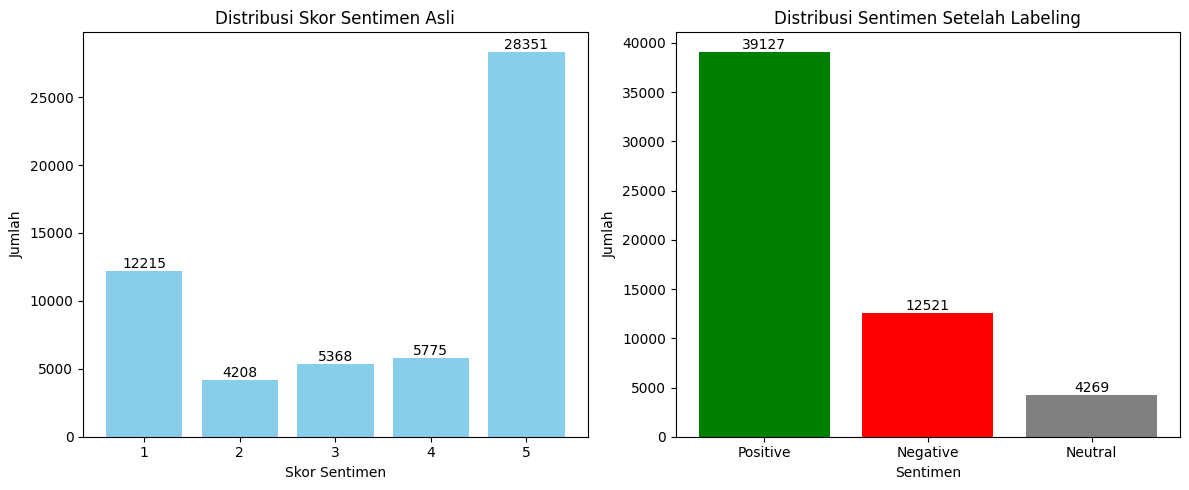

In [ ]:
def plot_class_distribution(df):
    plt.figure(figsize=(12, 5))

    # Sebelum labeling (Distribusi skor asli)
    plt.subplot(1, 2, 1)
    original_dist = df_loaded['score'].value_counts().sort_index()
    bars1 = plt.bar(original_dist.index, original_dist.values, color='skyblue')
    plt.title('Distribusi Skor Sentimen Asli')
    plt.xlabel('Skor Sentimen')
    plt.ylabel('Jumlah')

    # Tambahkan label pada batang
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5,
                 int(yval), ha='center', va='bottom', fontsize=10)

    # Setelah labeling (Distribusi sentimen kategori)
    plt.subplot(1, 2, 2)
    augmented_dist = df['labeling'].value_counts()
    colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'gray'}
    bars2 = plt.bar(augmented_dist.index, augmented_dist.values,
                    color=[colors[label] for label in augmented_dist.index])
    plt.title('Distribusi Sentimen Setelah Labeling')
    plt.xlabel('Sentimen')
    plt.ylabel('Jumlah')

    # Tambahkan label pada batang
    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5,
                 int(yval), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk visualisasi
plot_class_distribution(df_label)

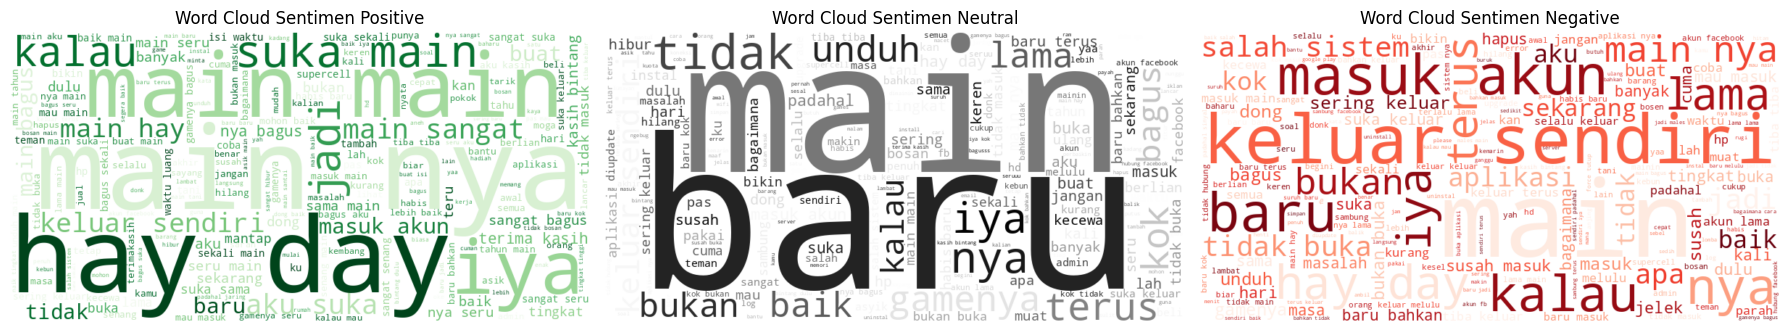

In [ ]:
# WordCloud untuk masing-masing sentimen
sentiment_labels = ['Positive', 'Neutral', 'Negative']
colors_wc = ['Greens', 'Greys', 'Reds']

plt.figure(figsize=(18, 6))

for i, (label, colormap) in enumerate(zip(sentiment_labels, colors_wc), 1):
    text = ' '.join(df_label[df_label['labeling'] == label]['hasil_akhir'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate(text)

    plt.subplot(1, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud Sentimen {label}')

plt.tight_layout()
plt.show()

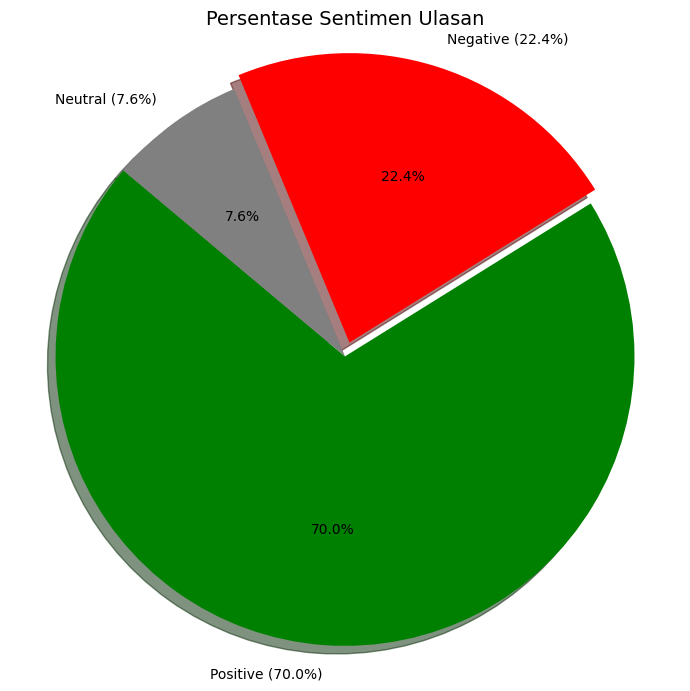

In [ ]:
# Hitung persentase tiap sentimen
sentiment_percent = df_label['labeling'].value_counts(normalize=True) * 100
sentiment_labels = sentiment_percent.index.tolist()
percent_values = sentiment_percent.values

# Pie chart
colors = ['green', 'red', 'grey']
explode = [0.05 if label.lower() == 'negative' else 0 for label in sentiment_labels]  # Memastikan kondisi sesuai

plt.figure(figsize=(7,7))
plt.pie(
    percent_values,
    labels=[f"{label.capitalize()} ({percent:.1f}%)" for label, percent in zip(sentiment_labels, percent_values)],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True
)
plt.title('Persentase Sentimen Ulasan', fontsize=14)
plt.axis('equal')  # Agar pie chart berbentuk lingkaran
plt.tight_layout()
plt.show()

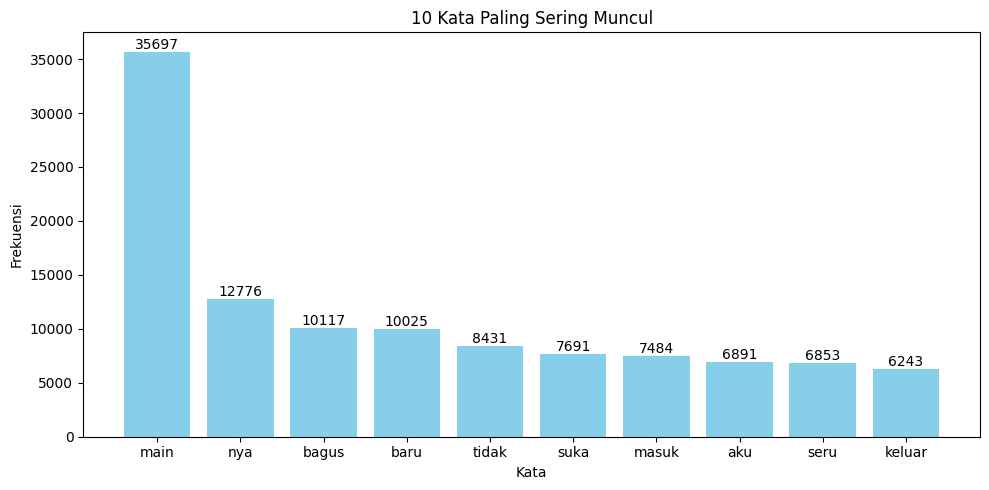

In [ ]:
# Kata yang digunakan terbanyak
# Gabungkan semua teks dari kolom 'hasil_akhir'
all_text = ' '.join(df_label['hasil_akhir'])
# Pisahkan jadi kata per kata
words = all_text.split()
# Hitung frekuensi kata
word_freq = Counter(words)
# Ambil 10 kata terbanyak
most_common_words = word_freq.most_common(10)

# Visualisasi Top 10 Kata
words_top, counts_top = zip(*most_common_words)
plt.figure(figsize=(10,5))
bars = plt.bar(words_top, counts_top, color='skyblue')
plt.title('10 Kata Paling Sering Muncul')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')

# Tambahkan label jumlah di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# **7. Persiapan Model**

In [ ]:
df_label

,content,score,at,hasil_akhir,clean,no_slang,labeling_score,labeling
0,masa aku kan beli brg hrsnya masuk ke lumbung ...,1,2021-04-07 13:01:57,masa aku kan beli bareng hrsnya masuk lumbung ...,masa aku kan beli brg hrsnya masuk ke lumbung ...,masa aku kan beli bareng hrsnya masuk ke lumbu...,6,Positive
1,kenapa mesti di update terusss.. padahal ndak ...,2,2019-06-25 12:52:57,mesti baru terusss padahal tidak brubahh cuma ...,kenapa mesti di update terusss.. padahal ndak ...,kenapa mesti di pembaruan terusss.. padahal ti...,-6,Negative
2,Permainan Yg Berbagi Ilmu,5,2019-06-23 11:03:04,main bagi ilmu,permainan yg berbagi ilmu,permainan yang berbagi ilmu,8,Positive
3,"Baru juga diupdate, udah di-update lagi.. 😠",1,2020-12-14 14:15:47,baru diupdate baru,"baru juga diupdate, udah di-update lagi..","baru juga diupdate, sudah di-update lagi..",0,Neutral
4,hay day menemani saya setiap hari,5,2019-01-26 23:35:29,hay day tani hari,hay day menemani saya setiap hari,hay day menemani saya setiap hari,1,Positive
...,...,...,...,...,...,...,...,...
55912,seru permainannya...,5,2019-06-24 14:53:09,seru main,seru permainannya...,seru permainannya...,7,Positive
55913,Wah permainan ini bagus sekali aku suka tpi ko...,5,2018-09-29 13:34:03,wah main bagus sekali aku suka kok nga sambung...,wah permainan ini bagus sekali aku suka tpi ko...,wah permainan ini bagus sekali aku suka tapi k...,11,Positive
55914,"Bagus, menyenangkan",5,2019-12-16 15:04:30,bagus senang,"bagus, menyenangkan","bagus, menyenangkan",7,Positive
55915,"Seru, gak bikin bosen dan gamenya santai",5,2024-12-24 13:50:04,seru bikin bosen gamenya santai,"seru, gak bikin bosen dan gamenya santai","seru, gak bikin bosen dan gamenya santai",3,Positive


In [ ]:
# Menampilkan baris-baris yang duplikat
duplicate_rows = df_label[df_label.duplicated()]
print(duplicate_rows)

# Menghitung jumlah baris duplikat
num_duplicates = df_label.duplicated().sum()
print("Jumlah baris duplikat:", num_duplicates)

Empty DataFrame
Columns: [content, score, at, hasil_akhir, clean, no_slang, labeling_score, labeling]
Index: []
Jumlah baris duplikat: 0


## Setup dan Konfigurasi

In [ ]:
# Hyperparameter
EMBED_DIM = 64
HIDDEN_UNITS = 128
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 20

In [ ]:
# Direktori model
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
class StopCallback(Callback):
    def __init__(self, target_accuracy=0.92):
        self.target_accuracy = target_accuracy
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None and logs.get('accuracy') >= self.target_accuracy:
            print(f'>>> Training dihentikan: Accuracy >= {self.target_accuracy}')
            self.model.stop_training = True

stop_training = StopCallback(target_accuracy=0.96)

In [ ]:
# Callback untuk semua model
def get_callbacks(name):
    return [
        EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True),
        stop_training,
        ReduceLROnPlateau(monitor='val_loss', patience=2),
        ModelCheckpoint(filepath=os.path.join(MODEL_DIR, f"best_{name}.keras"), save_best_only=True),
        TensorBoard(log_dir=f"logs/{name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
    ]


- **Early Stopping**: Hentikan training jika val_accuracy tidak membaik dalam 3 epoch.  
- **Model Checkpoint**: Simpan model terbaik berdasarkan val_accuracy.  
  


# **8. Pelatihan Model**

**Tokenisasi & Padding**  
- **Parameter**:  
  - `MAX_FEATURES=10,000`: Batasi kosakata ke 10.000 kata paling umum.  
  - `MAX_SEQUENCE_LENGTH=200`: Setiap teks dipotong/di-pad ke 200 token.  


#### **Encoding Label**  
- Label kategorikal (`Negative`, `Neutral`, `Positive`) diubah ke bentuk numerik dengan `LabelEncoder`.  
- Konversi ke format one-hot encoding menggunakan `to_categorical` untuk kompatibilitas model.  

#### **Stratified Data Splitting**  
- Pembagian data **80:20** (LSTM/GRU) dan **70:30** (BiLSTM) dengan `StratifiedShuffleSplit` untuk menjaga distribusi label.  



## Eksperimen 1: LSTM dengan Embedding (80/20 split)

In [ ]:
# Tokenisasi untuk eksperimen berbasis sequence (Embedding)
MAX_FEATURES = 10000
MAX_SEQUENCE_LENGTH = 200

tokenizer_seq = Tokenizer(num_words=MAX_FEATURES, oov_token='x')
# Ganti 'hasil_akhir' dengan 'clean' jika data sudah lebih bersih
tokenizer_seq.fit_on_texts(df_label['hasil_akhir'])
X_seq = tokenizer_seq.texts_to_sequences(df_label['hasil_akhir'])
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Encode label (dari df_label['labeling'])
le = LabelEncoder()
y_encoded = le.fit_transform(df_label['labeling'])
y_categorical = to_categorical(y_encoded)

# Split data dengan stratified 80/20
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X_pad, y_encoded):
    X_train_seq, X_test_seq = X_pad[train_index], X_pad[test_index]
    y_train_seq, y_test_seq = y_categorical[train_index], y_categorical[test_index]

print("Bentuk data training:", X_train_seq.shape, y_train_seq.shape)
print("Bentuk data testing :", X_test_seq.shape, y_test_seq.shape)

Bentuk data training: (44733, 200) (44733, 3)
Bentuk data testing : (11184, 200) (11184, 3)


In [ ]:
# Definisi model LSTM untuk Eksperimen 1
def create_lstm_model(vocab_size):
    model = Sequential([
        Embedding(vocab_size, EMBED_DIM, input_length=MAX_SEQUENCE_LENGTH),
        LSTM(HIDDEN_UNITS, return_sequences=True),
        BatchNormalization(),
        LSTM(HIDDEN_UNITS),
        Dropout(DROPOUT_RATE),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam (LEARNING_RATE),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

vocab_size = len(tokenizer_seq.word_index) + 1
lstm_model = create_lstm_model(vocab_size)
lstm_model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 64)             │       1,353,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 200, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 200, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,593,283 (6.08 MB)

 Trainable params: 1,593,027 (6.08 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
print("\n--- Eksperimen 1: LSTM dengan Embedding (80/20) ---")

history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks("LSTM"),
    verbose=1
)


--- Eksperimen 1: LSTM dengan Embedding (80/20) ---
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step - accuracy: 0.7926 - loss: 0.5197 - val_accuracy: 0.7529 - val_loss: 0.5833 - learning_rate: 0.0010
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.9220 - loss: 0.2120 - val_accuracy: 0.9187 - val_loss: 0.2165 - learning_rate: 0.0010
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.9476 - loss: 0.1416 - val_accuracy: 0.9254 - val_loss: 0.2090 - learning_rate: 0.0010
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9596 - loss: 0.1061>>> Training dihentikan: Accuracy >= 0.96
350/350 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.9596 - loss: 0.1061 - val_accuracy: 0.8664 - val_loss: 0.3784 - learning_rate: 0.0010


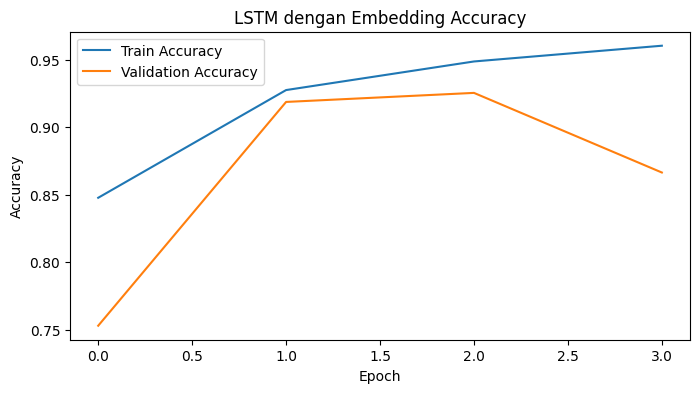

In [ ]:
# Plot hasil training
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM dengan Embedding Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Eksperimen 2: BiLSTM dengan Embedding Layer trainable (70/30 split)

In [ ]:
# Konversi teks ke urutan angka menggunakan tokenizer (pastikan X_tokenized sudah didefinisikan)
X_tokenized = X_seq
X_padded = pad_sequences(X_tokenized, maxlen=100, padding='post')  # maxlen langsung diisi 100

# Split data 70/30 menggunakan StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(X_padded, y_encoded):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

print("Bentuk data training:", X_train.shape, y_train.shape)
print("Bentuk data testing :", X_test.shape, y_test.shape)

Bentuk data training: (39141, 100) (39141, 3)
Bentuk data testing : (16776, 100) (16776, 3)


In [ ]:
def create_bilstm_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Embedding layer trainable: VOCAB_SIZE=20000, output_dim=128, input_length=100
    embedding = Embedding(input_dim=20000, output_dim=128, input_length=100, trainable=True)(input_layer)

    # BiLSTM Layer dengan 128 unit
    x = Bidirectional(LSTM(128, return_sequences=False))(embedding)

    # Fully connected layer
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer untuk klasifikasi 3 kelas
    output_layer = Dense(3, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Inisialisasi dan ringkasan model
bilstm_model = create_bilstm_model(input_shape=(100,))
bilstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 100, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,839,811 (10.83 MB)

 Trainable params: 2,839,811 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\n--- BiLSTM dengan Embedding Layer trainable (70/30) ---")

history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks("BiLSTM"),
    verbose=1
)


--- BiLSTM dengan Embedding Layer trainable (70/30) ---
Epoch 1/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 273s 856ms/step - accuracy: 0.7678 - loss: 0.6028 - val_accuracy: 0.8796 - val_loss: 0.3277 - learning_rate: 0.0010
Epoch 2/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 258s 843ms/step - accuracy: 0.9022 - loss: 0.2709 - val_accuracy: 0.9210 - val_loss: 0.2225 - learning_rate: 0.0010
Epoch 3/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 263s 846ms/step - accuracy: 0.9444 - loss: 0.1509 - val_accuracy: 0.9222 - val_loss: 0.2157 - learning_rate: 0.0010
Epoch 4/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.9613 - loss: 0.1073>>> Training dihentikan: Accuracy >= 0.96
306/306 ━━━━━━━━━━━━━━━━━━━━ 261s 851ms/step - accuracy: 0.9613 - loss: 0.1073 - val_accuracy: 0.9366 - val_loss: 0.1907 - learning_rate: 0.0010


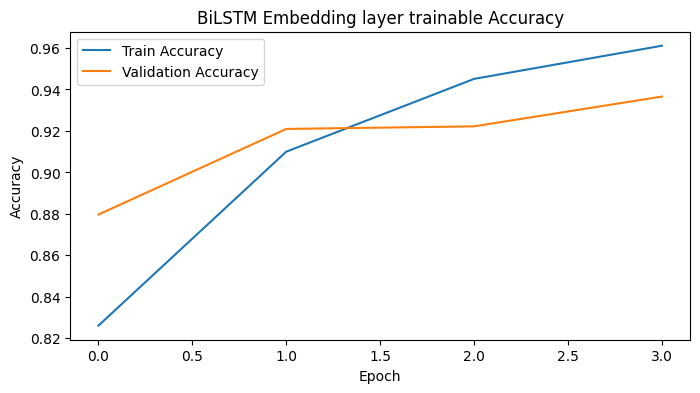

In [ ]:
# Plot hasil training Eksperimen 2
plt.figure(figsize=(8,4))
plt.plot(history_bilstm .history['accuracy'], label='Train Accuracy')
plt.plot(history_bilstm .history['val_accuracy'], label='Validation Accuracy')
plt.title('BiLSTM Embedding layer trainable Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Eksperimen 3: GRU dengan Embedding (80/20 split)

In [ ]:
# Gunakan data sequence yang sama dari tokenizer_seq dan X_pad
# Tokenisasi untuk eksperimen berbasis sequence (Embedding)
MAX_FEATURES = 10000
MAX_SEQUENCE_LENGTH = 200

tokenizer_seq = Tokenizer(num_words=MAX_FEATURES, oov_token='x')
tokenizer_seq.fit_on_texts(df_label['hasil_akhir'])
X_seq = tokenizer_seq.texts_to_sequences(df_label['hasil_akhir'])
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Encode label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(df_label['labeling'])
y_categorical = to_categorical(y_encoded)

# Split data GRU (80/20 split) dengan StratifiedShuffleSplit
sss_gru = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss_gru.split(X_pad, y_encoded):
    X_train_seq_gru, X_test_seq_gru = X_pad[train_index], X_pad[test_index]
    y_train_seq_gru, y_test_seq_gru = y_categorical[train_index], y_categorical[test_index]

print("Bentuk data training GRU:", X_train_seq_gru.shape, y_train_seq_gru.shape)
print("Bentuk data testing GRU :", X_test_seq_gru.shape, y_test_seq_gru.shape)

Bentuk data training GRU: (44733, 200) (44733, 3)
Bentuk data testing GRU : (11184, 200) (11184, 3)


In [ ]:
# Definisi model GRU
def create_gru_model(vocab_size):
    model = Sequential([
        Embedding(vocab_size, EMBED_DIM, input_length=MAX_SEQUENCE_LENGTH),
        GRU(HIDDEN_UNITS, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),  # Meningkatkan dropout rate ke 0.5
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

vocab_size_gru = len(tokenizer_seq.word_index) + 1
gru_model = create_gru_model(vocab_size_gru)
gru_model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
gru_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 200, 64)             │       1,353,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,437,379 (5.48 MB)

 Trainable params: 1,437,123 (5.48 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
print("\n--- GRU dengan Embedding (80/20) ---")

history_gru = gru_model.fit(
    X_train_seq_gru, y_train_seq_gru,
    validation_data=(X_test_seq_gru, y_test_seq_gru),
    epochs=10,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks("GRU"),
    verbose=1
)


--- GRU dengan Embedding (80/20) ---
Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 283s 784ms/step - accuracy: 0.7210 - loss: 0.7615 - val_accuracy: 0.7057 - val_loss: 0.7154 - learning_rate: 0.0010
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 322s 786ms/step - accuracy: 0.8938 - loss: 0.3584 - val_accuracy: 0.7770 - val_loss: 0.5866 - learning_rate: 0.0010
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 349s 863ms/step - accuracy: 0.9235 - loss: 0.2615 - val_accuracy: 0.7208 - val_loss: 0.9394 - learning_rate: 0.0010
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 296s 788ms/step - accuracy: 0.9393 - loss: 0.2052 - val_accuracy: 0.9045 - val_loss: 0.2984 - learning_rate: 0.0010
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 276s 787ms/step - accuracy: 0.9518 - loss: 0.1693 - val_accuracy: 0.9024 - val_loss: 0.3575 - learning_rate: 0.0010
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 353s 877ms/step - accuracy: 0.9549 - loss: 0.1485 - val_accuracy: 0.9181 - val_loss: 0.2651 - learning_rate: 0.0010
Epoch 7/10
350/350 ━━━━━━━

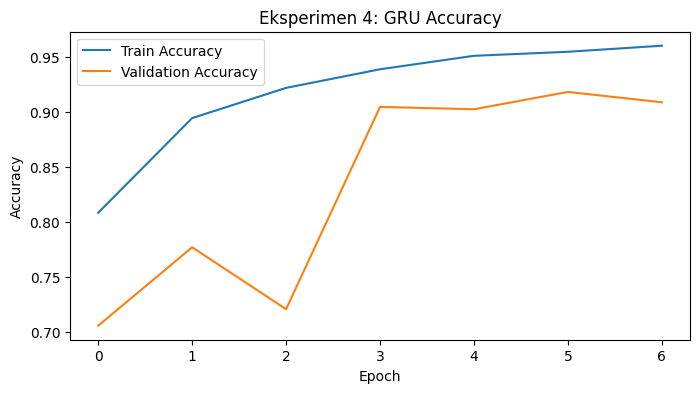

In [ ]:
# Plot hasil training Eksperimen 3
plt.figure(figsize=(8,4))
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('Eksperimen 4: GRU Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **8. Evaluasi Model**

350/350 ━━━━━━━━━━━━━━━━━━━━ 103s 294ms/step
Confusion Matrix - Eksperimen (LSTM):


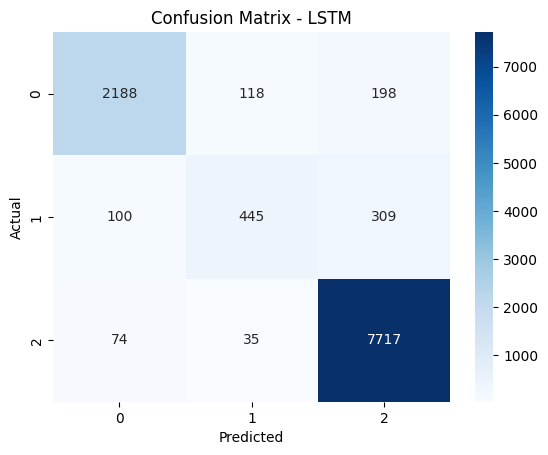

Classification Report - Eksperimen  (LSTM):
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      2504
           1       0.74      0.52      0.61       854
           2       0.94      0.99      0.96      7826

    accuracy                           0.93     11184
   macro avg       0.87      0.79      0.82     11184
weighted avg       0.92      0.93      0.92     11184



In [ ]:
# Evaluasi Eksperimen 1 LSTM
y_pred = np.argmax(lstm_model.predict(X_test_seq), axis=1)
y_true = np.argmax(y_test_seq, axis=1)
print("Confusion Matrix - Eksperimen (LSTM):")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("Classification Report - Eksperimen  (LSTM):")
print(classification_report(y_true, y_pred))

525/525 ━━━━━━━━━━━━━━━━━━━━ 95s 181ms/step
Confusion Matrix - Eksperimen (BiLSTM):


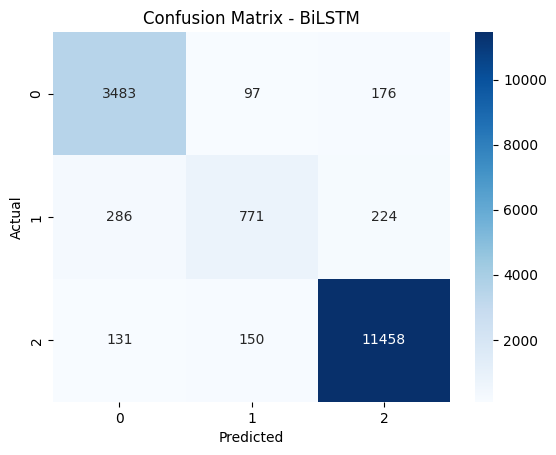

Classification Report - Eksperimen 5 (BiLSTM):
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3756
           1       0.76      0.60      0.67      1281
           2       0.97      0.98      0.97     11739

    accuracy                           0.94     16776
   macro avg       0.87      0.84      0.85     16776
weighted avg       0.93      0.94      0.93     16776



In [ ]:
# Evaluasi Eksperimen 2
y_pred = np.argmax(bilstm_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("Confusion Matrix - Eksperimen (BiLSTM):")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - BiLSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Classification Report - Eksperimen 5 (BiLSTM):")
print(classification_report(y_true, y_pred))

350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step
Confusion Matrix - Eksperimen (GRU):


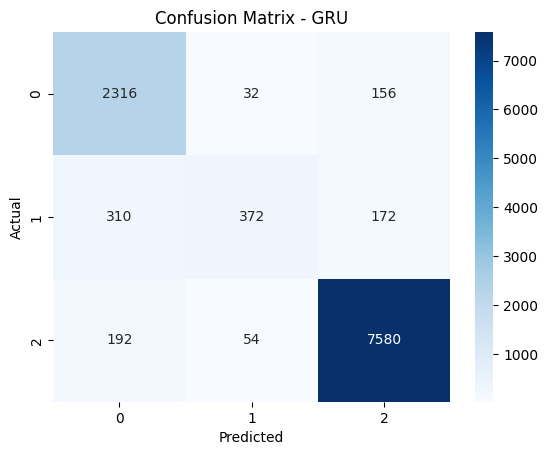

Classification Report - Eksperimen (GRU):
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2504
           1       0.81      0.44      0.57       854
           2       0.96      0.97      0.96      7826

    accuracy                           0.92     11184
   macro avg       0.86      0.78      0.80     11184
weighted avg       0.92      0.92      0.91     11184



In [ ]:
# Evaluasi model GRU
y_pred_gru = np.argmax(gru_model.predict(X_test_seq_gru), axis=1)
y_true_gru = np.argmax(y_test_seq_gru, axis=1)
print("Confusion Matrix - Eksperimen (GRU):")
cm_gru = confusion_matrix(y_true_gru, y_pred_gru)
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GRU')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("Classification Report - Eksperimen (GRU):")
print(classification_report(y_true_gru, y_pred_gru))

## Perbandingan Akurasi Model

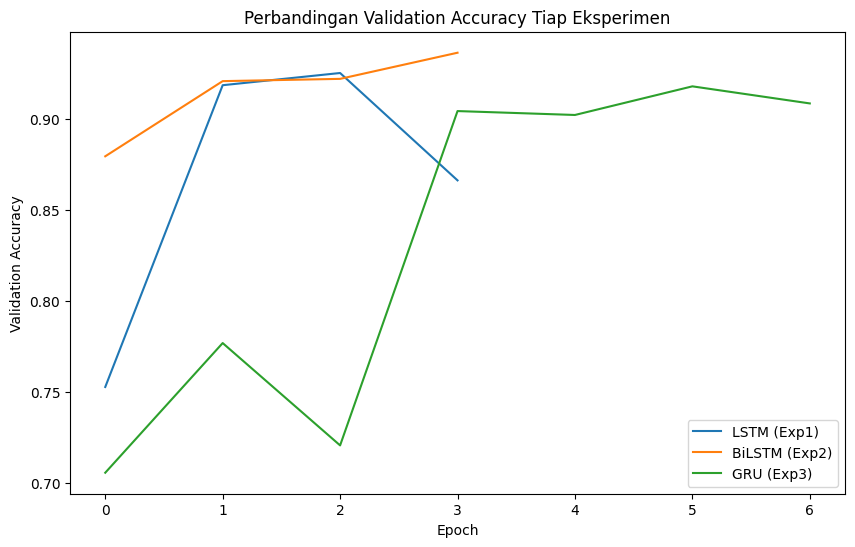

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history_lstm.history['val_accuracy'], label='LSTM (Exp1)')
plt.plot(history_bilstm.history['val_accuracy'], label='BiLSTM (Exp2)')
plt.plot(history_gru.history['val_accuracy'], label='GRU (Exp3)')
plt.title('Perbandingan Validation Accuracy Tiap Eksperimen')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

In [ ]:
# Ekstrak akurasi dari history setiap model (menggunakan epoch terakhir)
lstm_train_acc = history_lstm.history['accuracy'][-1]
lstm_val_acc   = history_lstm.history['val_accuracy'][-1]

bilstm_train_acc = history_bilstm.history['accuracy'][-1]
bilstm_val_acc   = history_bilstm.history['val_accuracy'][-1]

gru_train_acc = history_gru.history['accuracy'][-1]
gru_val_acc   = history_gru.history['val_accuracy'][-1]

# Buat DataFrame untuk perbandingan
data = {
    "Model": ["LSTM", "Bi-LSTM", "GRU"],
    "Accuracy Train": [lstm_train_acc, bilstm_train_acc, gru_train_acc],
    "Accuracy Test":  [lstm_val_acc, bilstm_val_acc, gru_val_acc]
}

df_comparison = pd.DataFrame(data)
print("Perbandingan Akurasi Model:")
print(df_comparison)

Perbandingan Akurasi Model:
     Model  Accuracy Train  Accuracy Test
0     LSTM        0.960387       0.866416
1  Bi-LSTM        0.961089       0.936576
2      GRU        0.960074       0.908709


# **9. Model Testing**

In [ ]:
# Misalkan 'new_text' adalah teks ulasan baru yang ingin diinferensikan.
new_text = "Grafik biasa saja, tidak worth it harganya"

# Lakukan preprocessing pada teks baru sesuai pipeline kamu
# Misalnya, jika kamu sudah memiliki fungsi preprocessor.clean()
new_text_processed = preprocessor.clean(new_text)  # Pastikan 'preprocessor' sudah didefinisikan

# Tokenisasi menggunakan tokenizer_seq yang sudah fit pada data training
new_seq = tokenizer_seq.texts_to_sequences([new_text_processed])

# Padding agar panjangnya sama dengan input model (misalnya 100 untuk BiLSTM)
new_pad = pad_sequences(new_seq, maxlen=100)

# Lakukan prediksi dengan model BiLSTM (misalnya bilstm_model)
prediction = bilstm_model.predict(new_pad)

# Ambil indeks kelas dengan probabilitas tertinggi
predicted_class_index = prediction.argmax(axis=1)[0]

# Konversi indeks ke label kategorikal menggunakan LabelEncoder yang sudah fit
predicted_label = le.inverse_transform([predicted_class_index])[0]

print("Prediksi sentimen:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Prediksi sentimen: Neutral


In [ ]:
# Fungsi inference yang lebih robust
def predict_sentiment(new_text, model, tokenizer, preprocessor, le, max_length):
    try:
        # Preprocessing
        new_text_processed = preprocessor.clean(new_text)

        # Tokenisasi & padding
        new_seq = tokenizer.texts_to_sequences([new_text_processed])
        new_pad = pad_sequences(new_seq, maxlen=max_length, padding='post')

        # Prediksi
        prediction = model.predict(new_pad, verbose=0)
        predicted_class_index = prediction.argmax(axis=1)[0]
        predicted_label = le.inverse_transform([predicted_class_index])[0]

        return {
            "text": new_text,
            "processed_text": new_text_processed,
            "sentiment": predicted_label,
            "confidence": float(prediction.max())
        }
    except Exception as e:
        return {
            "text": new_text,
            "error": str(e)
        }

# Contoh penggunaan
new_texts = [
    "Saya sangat menyukai permainan ini, seru dan menghibur",
    "Tidak direkomendasikan karena membosankan",
    "Suka keluar sendiri",
    "Game ini payah dan boros baterai"
]

for text in new_texts:
    result = predict_sentiment(
        new_text=text,
        model=bilstm_model,  # Ganti dengan model yang ingin diuji
        tokenizer=tokenizer_seq,  # Tokenizer dari training
        preprocessor=preprocessor,  # Instance EnhancedGamePreprocessor
        le=le,  # LabelEncoder dari training
        max_length=100  # Sesuaikan dengan model: 100 untuk BiLSTM, 200 untuk LSTM/GRU
    )
    print(f"Text: {result['text']}")
    print(f"Sentimen: {result['sentiment']} (Confidence: {result['confidence']:.2f})")
    print("=" * 50)

Text: Saya sangat menyukai permainan ini, seru dan menghibur
Sentimen: Positive (Confidence: 1.00)
Text: Tidak direkomendasikan karena membosankan
Sentimen: Neutral (Confidence: 0.95)
Text: Suka keluar sendiri
Sentimen: Negative (Confidence: 1.00)
Text: Game ini payah dan boros baterai
Sentimen: Negative (Confidence: 0.94)


Kesimpulan dari analisis model dan implementasi inferensi menunjukkan bahwa model Bi-LSTM merupakan pilihan terbaik dengan akurasi testing mencapai 93.66% dan selisih tipis antara akurasi training (96.11%) yang menunjukkan kemampuan generalisasi yang baik. Model LSTM meskipun memiliki akurasi training tinggi (96.04%) namun mengalami overfitting yang terlihat dari penurunan signifikan pada akurasi testing (86.64%), sementara GRU menawarkan keseimbangan dengan akurasi testing 90.87%. Dalam implementasi inferensi, fungsi predict_sentiment berhasil menangani teks baru secara robust melalui tahapan preprocessing, tokenisasi, dan prediksi, meskipun masih terdapat keterbatasan dalam menangani kasus negasi seperti pada kalimat "Tidak direkomendasikan" yang seharusnya bernilai negatif tetapi terprediksi sebagai neutral. Hasil prediksi juga dilengkapi dengan confidence score yang membantu menilai reliabilitas prediksi.

# **10. Requirement**

In [ ]:
pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.14
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.17.0.34.53
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.41.0
bigquery-magics==0.8.0
bleach==6.2.0
blinker==1.9.0
blis==1.2.0
blosc2==3.2.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
